# Model Selection: `model_1` vs `model_2a`

* This notebook reproduces one of the Bayes factors found in figure 3 of the 12.5 year GWB search paper

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import json
import matplotlib.pyplot as plt
import numpy as np

from enterprise_extensions import models, model_utils, hypermodel

from settings import fd_bins, load_pulsars

Do not have mpi4py package.
Do not have acor package


libstempo not installed. Will use PINT instead.


## Get par, tim, and noise files

In [2]:
datadir = './data'

In [3]:
# load the pulsars (picking PINT or TEMPO2 timing packages and the ephemeris)
# set save = True to save a pickle and reduce load times significantly (at the cost of 1.8GB of space.)
psrs = load_pulsars(datadir, PINT=True, ephemeris='DE438', save=True)

In [7]:
## Get parameter noise dictionary
noise_ng12 = datadir + '/channelized_12p5yr_v3_full_noisedict.json'

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

* We want to be able to compute the posterior odds ratio for a signal in the data. This can be done using the hypermodel class, where we choose between a `model_2a` with a common (but uncorrelated) red process in the pulsars, and `model_1` with only intrinsic red noise in the model.

* We typically perform detection-type analyses with uniform-in-log priors on all amplitude parameters for low-frequency processes. This is implemented below with `upper_limit` equal to `False`.

## Setup dictionary of PTA models
* `model_1` consists of a PTA with only intrinsic red noise
* `model_2a` includes a common red process where (for this analysis) we set the spectral index to 13/3
* We also change `n_gwbfreqs` to only include the lowest 5 frequencies to match closely with the 12.5 year SGWB search
* There are other model functions built into `enterprise_extensions`.
* Check out the documentation of each function in the `models.py` file of `enterprise_extensions` for more information.

* With recent changes, a couple new parameters have been added:
* The default white noise parameters have been changed, so we use `tnequad=True`
* A new method of likelihood evaluation has been implemented (faster and returns the same result): `tm_marg=True`
* We now use the SVD on timing model design matrices to make sure they are well conditioned: `tm_svd=True`

In [13]:
nmodels = 2
mod_index = np.arange(nmodels)

# Make dictionary of PTAs.
pta = dict.fromkeys(mod_index)
pta[0] = models.model_1(psrs, noisedict=params,
                        tnequad=True, tm_marg=True, tm_svd=True)
pta[1] = models.model_2a(psrs, noisedict=params, n_gwbfreqs=5, gamma_common=13/3,
                         tnequad=True, tm_marg=True, tm_svd=True)

* In setting up the `HyperModel` in the next cell, we set weights to make the models sample more evenly.
* `log_weights` is a list with the same length as the models, and each entry is added to the corresponding log-likelihood
* To undo the weights, we will divide each fraction by the exponential of the `log_weights`

In [14]:
super_model = hypermodel.HyperModel(pta, log_weights=[10, 0])

## Sample

In [15]:
outDir = './output/chains/ms_12a_chains'
sampler = super_model.setup_sampler(resume=True, outdir=outDir, sample_nmodel=True,)

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...

Adding nmodel uniform distribution draws...



In [12]:
# sampler for N steps
N = int(5e6)  # 5e6 is a good number for a real analysis
x0 = super_model.initial_sample()

In [10]:
# sample
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

In [11]:
# uncomment this line if you sampled yourself:
# chain = np.loadtxt(outDir + '/chain_1.txt')

# this line will load the chains that we have provided:
chain = np.load(outDir + '/chain_1.npz')['arr_0']

burn = int(0.1 * chain.shape[0])
pars = np.loadtxt(outDir + '/pars.txt', dtype=np.unicode_)

ind_model = list(pars).index('nmodel')

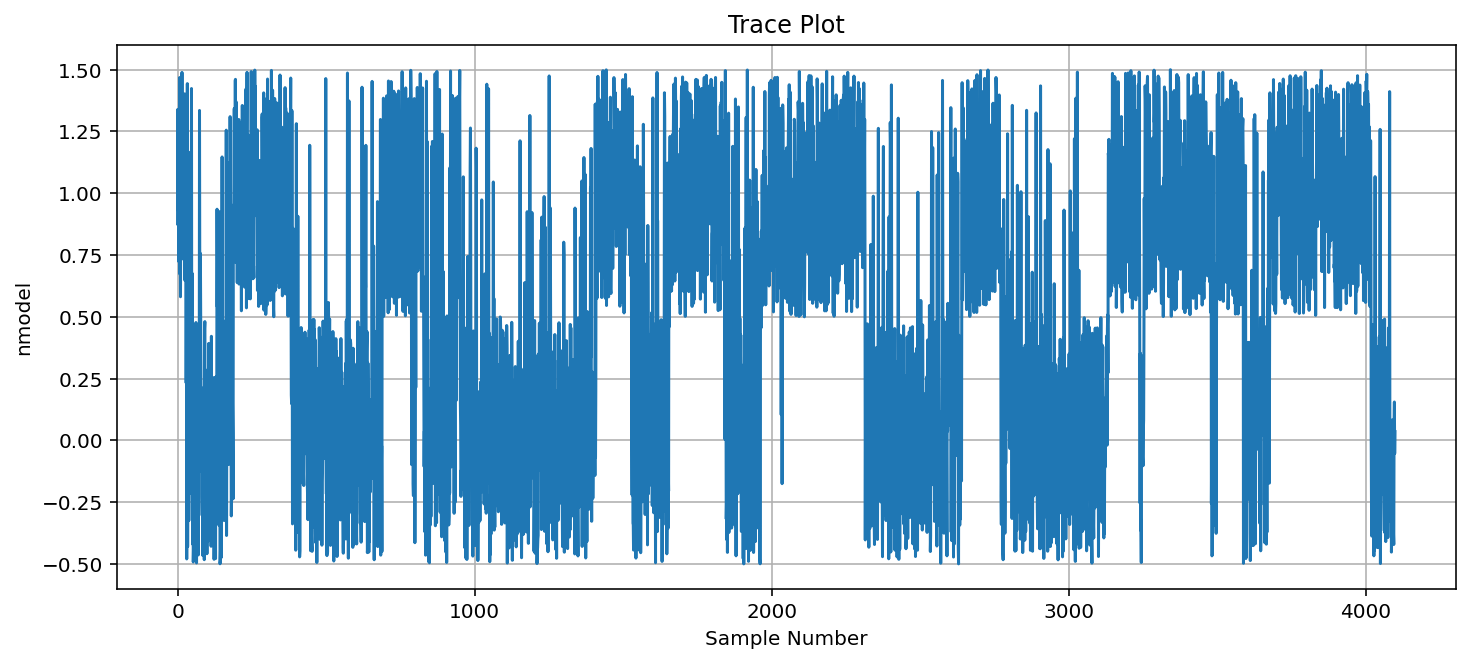

In [12]:
# Make trace-plot to diagnose sampling
# We want this plot to look more like a fuzzy caterpillar than a skinny worm
plt.figure(figsize=(12, 5))
plt.plot(chain[burn:, ind_model])
plt.xlabel('Sample Number')
plt.ylabel('nmodel')
plt.title('Trace Plot')
plt.grid(b=True)
plt.show()

In [13]:
# Plot histgram for GW amplitude
chain_burn = chain[burn:,:]

ind_model = list(pars).index('nmodel')
ind_gwamp = list(pars).index('gw_log10_A')

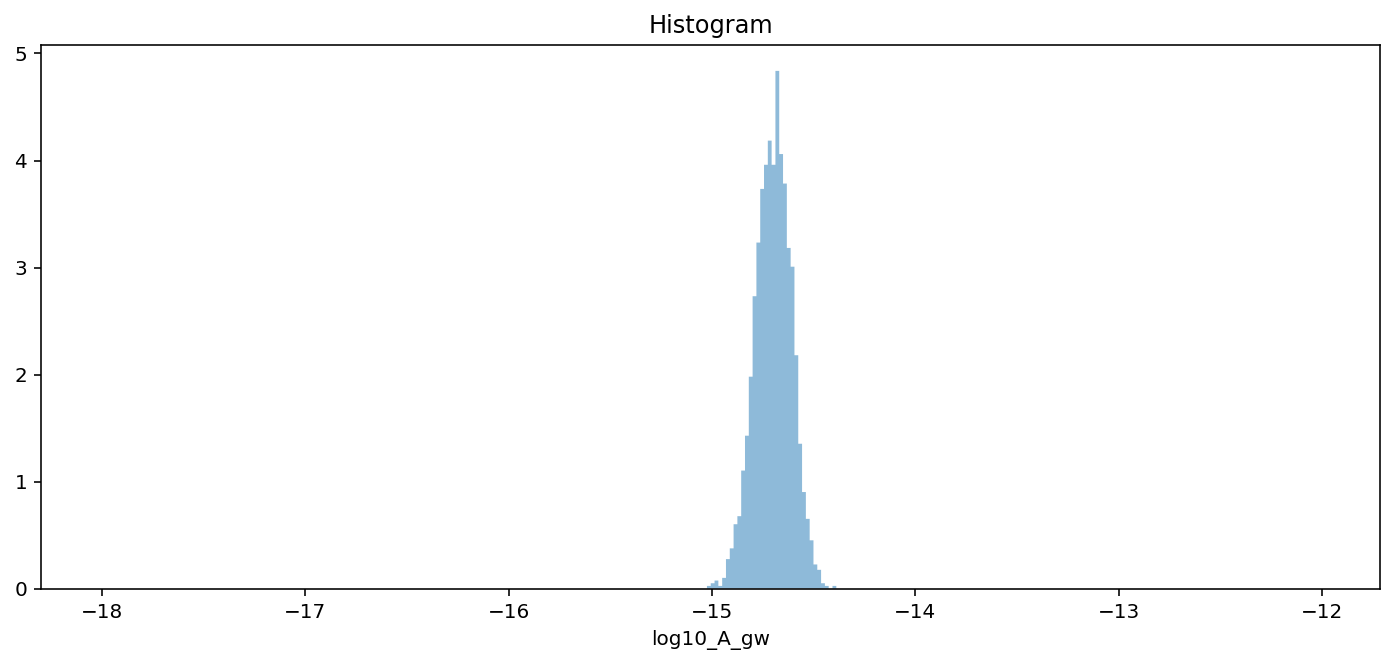

In [14]:
# Plot a histogram of the marginalized posterior distribution for ind_model > 0.5 (includes common red process)
bins = fd_bins(chain_burn[chain_burn[:, ind_model] > 0.5, ind_gwamp], logAmin=-18, logAmax=-12)  # let FD rule decide bins (in ../settings.py)
plt.figure(figsize=(12, 5))
plt.title('Histogram')
plt.hist(chain_burn[chain_burn[:, ind_model] > 0.5, ind_gwamp], bins=bins, histtype='stepfilled',
         lw=2, color='C0', alpha=0.5, density=True)
plt.xlabel('log10_A_gw')
plt.show()

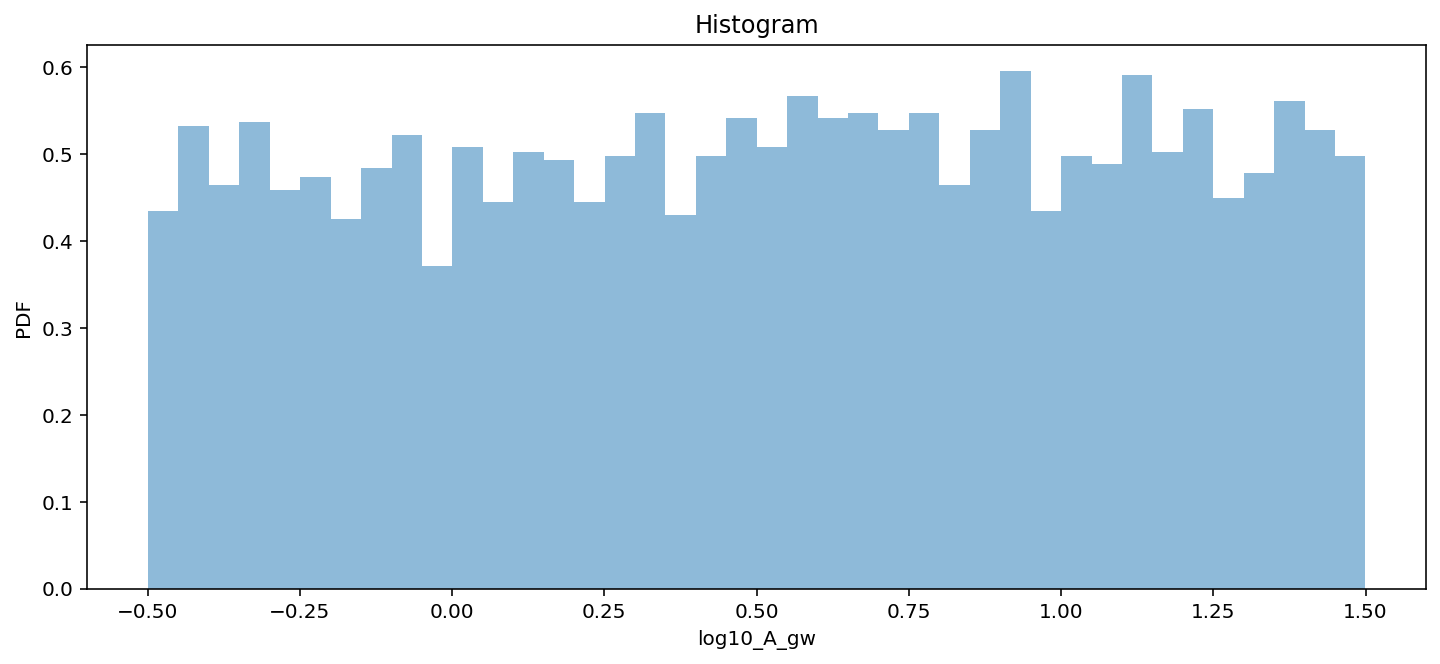

In [15]:
# Plot histogram for GWB model selection
# This will tell us how much we have sampled for each model
plt.figure(figsize=(12, 5))
plt.title('Histogram')
plt.hist(chain_burn[:, ind_model], bins=40, histtype='stepfilled',
         lw=2, color='C0', alpha=0.5, density=True)
plt.xlabel('log10_A_gw')
plt.ylabel('PDF')
plt.show()

### Hypermodel

* The `HyperModel` has approximately equivalent numbers of samples in each model, but the first model is strongly weighted.
* This implies that the second model is **strongly** favored.
* To undo the `log_weights` from earlier, we multiply the posterior odds ratio by $e^{10}$.


### Posterior odds ratio

* This gives the posterior odds ratio between a model with intrinsic red noise only (`model_1`), and a common (but uncorrelated) red process between pulsars (`model_2a`). 
* This will tell us if the pulsars prefer a common red noise term over no common term, but it will not tell us if this is the GWB.
* We will return to this in the next section to compare between a common (uncorrelated) red noise term and a red noise term with Hellings and Downs (HD) correlations.
* HD correlations would indicate that the common signal is a gravitational wave background.
* The posterior odds ratio here indicates that there is **strong** evidence for a common red noise signal among pulsars

In [16]:
# The first number is the posterior odds ratio (POR) and the second number is the uncertainty on the POR
por, unc = model_utils.odds_ratio(chain_burn[:, ind_model], models=[0,1])
print(por, unc)

1.0838840874428064 0.10169223246374437


In [17]:
log10por = np.log10(por*np.exp(10))  # we multiply by exp(10) to undo the log_weight of 10
print(log10por)

4.377927659467717


* The posterior odds ratio is nearly what was published in the 12.5 year stochastic GWB search where a value of 4.5 was found